# Premier League Striker Efficiency Analysis (2024–2025 Season)
**Name:** Samuel Gebreyohannes

## 1. Dataset Origin and Importance

“The dataset used in this project comes from Kaggle, where a user compiled detailed Premier League player statistics for the 2024–2025 season using information originally sourced from FBref, a public football statistics website.”

Source URL:
https://www.kaggle.com/datasets/eduardopalmieri/premier-league-player-stats-season-2425
From this Kaggle page, I downloaded the CSV file named database.csv and uploaded it into my Jupyter environment in Vocareum.

This dataset is valuable because it contains both chance quality metrics (expected goals, xG) and actual scoring output (goals per 90 minutes). These advanced stats make it possible to analyze striker efficiency—how well players convert scoring opportunities into goals—and they provide insights useful for coaches, analysts, and scouts.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load the CSV downloaded from FBref
df = pd.read_csv("database.csv")

# Preview the first few rows and the column names
display(df.head())
print(df.columns)

,Player,Team,#,Nation,Position,Age,Minutes,Goals,Assists,Penalty Shoot on Goal,...,Goal-Creating Actions,Passes Completed,Passes Attempted,Pass Completion %,Progressive Passes,Carries,Progressive Carries,Dribble Attempts,Successful Dribbles,Date
0,Bruno Fernandes,Manchester United,8,POR,"FW,AM",29-343,90,0,0,0,...,0,43,60,"71,7",6,50,7,1,1,2024-08-16
1,Marcus Rashford,Manchester United,10,ENG,LW,26-290,90,0,0,0,...,0,22,30,"73,3",2,34,2,6,0,2024-08-16
2,Amad Diallo,Manchester United,16,CIV,RW,22-036,60,0,0,0,...,0,28,33,"84,8",1,22,0,1,1,2024-08-16
3,Alejandro Garnacho,Manchester United,17,ARG,RW,20-046,30,0,1,0,...,1,10,11,"90,9",0,11,2,2,0,2024-08-16
4,Mason Mount,Manchester United,7,ENG,AM,25-219,60,0,0,0,...,0,11,15,"73,3",1,16,0,2,0,2024-08-16


Index(['Player', 'Team', '#', 'Nation', 'Position', 'Age', 'Minutes', 'Goals',
       'Assists', 'Penalty Shoot on Goal', 'Penalty Shoot', 'Total Shoot',
       'Shoot on Target', 'Yellow Cards', 'Red Cards', 'Touches', 'Dribbles',
       'Tackles', 'Blocks', 'Expected Goals (xG)', 'Non-Penalty xG (npxG)',
       'Expected Assists (xAG)', 'Shot-Creating Actions',
       'Goal-Creating Actions', 'Passes Completed', 'Passes Attempted',
       'Pass Completion %', 'Progressive Passes', 'Carries',
       'Progressive Carries', 'Dribble Attempts', 'Successful Dribbles',
       'Date'],
      dtype='object')


## 2. Cleaning and Preparing the Data

To focus on the relationship between chance quality and scoring for strikers, I will:

1. **Filter for strikers/forwards** by keeping only rows where the position contains `"FW"`.
2. **Require a minimum number of minutes played (at least 90 minutes so that per-90 statistics are based on at least one full match).
3. **Use goals per 90 minutes (G/90)** and **expected goals per 90 minutes (xG/90)** as the main variables.
4. Convert these columns to numeric types and remove any rows with missing values in these key statistics.

In [2]:
# 1. Filter for forwards (position includes "FW")
strikers = df[df["Position"].str.contains("FW", na=False)].copy()

# 2. Keep only players with at least 400 minutes
strikers = strikers[strikers["Minutes"] >= 90].copy()

# 3. Compute per-90 stats from totals
minutes_factor = strikers["Minutes"] / 90.0

strikers["Gls_per_90"] = strikers["Goals"] / minutes_factor
strikers["xG_per_90"] = strikers["Expected Goals (xG)"] / minutes_factor

# 4. Drop any rows missing these key stats
strikers = strikers.dropna(subset=["Gls_per_90", "xG_per_90"])

# 5. Check how many strikers we have and preview data
len(strikers), strikers[["Player", "Team", "Position", "Minutes", "Goals",
                         "Expected Goals (xG)", "Gls_per_90", "xG_per_90"]].head()


(152,
               Player                    Team  Position  Minutes  Goals  \
 0    Bruno Fernandes       Manchester United     FW,AM       90      0   
 63    Alexander Isak        Newcastle United        FW       90      0   
 79    Adam Armstrong             Southampton        FW       90      0   
 109  Antoine Semenyo             Bournemouth  LW,RW,FW       90      1   
 139    Danny Welbeck  Brighton & Hove Albion        FW       90      1   
 
      Expected Goals (xG)  Gls_per_90  xG_per_90  
 0                    1.2         0.0        1.2  
 63                   0.0         0.0        0.0  
 79                   0.7         0.0        0.7  
 109                  0.4         1.0        0.4  
 139                  0.2         1.0        0.2  )

## 3. Histogram Analysis: Distribution of xG per 90

First, I will create a histogram of **expected goals per 90 minutes (xG/90)** for strikers.  
This shows how scoring chance quality is distributed among forwards in the league.

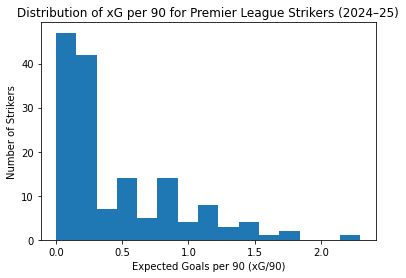

In [3]:
plt.hist(strikers["xG_per_90"], bins=15)
plt.title("Distribution of xG per 90 for Premier League Strikers (2024–25)")
plt.xlabel("Expected Goals per 90 (xG/90)")
plt.ylabel("Number of Strikers")
plt.show()

The histogram shows that most strikers have relatively modest xG per 90 values, clustered toward the lower end of the range, with a smaller number of players in the higher xG/90 bins. This right-skewed distribution suggests that only a few strikers consistently receive many or very high-quality scoring chances, while the majority generate a more average level of xG/90. 

In other words, scoring opportunities are concentrated in a small group of top forwards, which is consistent with the idea that some players and teams are much more effective at creating chances than others.

## 4. Secondary Analysis: Relationship Between xG/90 and Goals/90

**Question:**  
Does having a higher expected goals per 90 rate (xG/90) lead to a higher actual goals per 90 rate (G/90) among Premier League strikers in the 2024–2025 season?

To investigate this, I will:

1. Create a scatter plot of xG/90 (horizontal axis) vs G/90 (vertical axis).
2. Fit a simple linear regression line.
3. Compute the correlation coefficient to quantify the strength of the relationship.

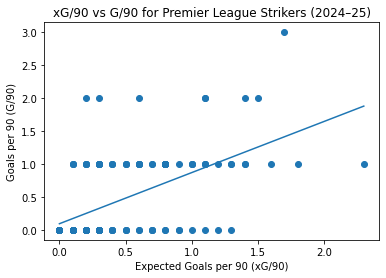

Correlation (r): 0.5724601039202929
Slope: 0.7759485603589152
p-value: 1.307579997286572e-14


In [4]:
x = strikers["xG_per_90"]
y = strikers["Gls_per_90"]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Scatter plot
plt.scatter(x, y)
plt.xlabel("Expected Goals per 90 (xG/90)")
plt.ylabel("Goals per 90 (G/90)")
plt.title("xG/90 vs G/90 for Premier League Strikers (2024–25)")

# Regression line
x_vals = sorted(x)
y_pred = [slope * v + intercept for v in x_vals]
plt.plot(x_vals, y_pred)

plt.show()

print("Correlation (r):", r_value)
print("Slope:", slope)
print("p-value:", p_value)

The scatter plot shows an overall upward trend: strikers with higher xG per 90 minutes tend to record higher goals per 90 minutes. The fitted regression line also slopes upward, and the positive correlation coefficient (r) confirms this relationship.

This means that, in general, players who consistently get into better or more frequent scoring positions (high xG/90) do convert those chances into more goals per 90. However, the points do not all lie perfectly on the line. 

Strikers above the line are **over-performers**, scoring more goals than expected from their xG, while those below the line are **under-performers**, scoring fewer goals than expected. This is useful for identifying players whose finishing may be unusually strong or unusually poor relative to the quality of chances they receive.

## 5. Stakeholders and What They Learn

**Stakeholder 1: Club Coaching and Tactical Staff**

Coaches and performance analysts inside clubs can use this analysis to evaluate whether their strikers are finishing chances at an expected rate. A striker with high xG/90 but relatively low G/90 may need targeted finishing drills or better decision-making in the box. A striker far above the regression line may be in an unusually hot finishing streak, which could be expected to regress toward their xG over time. This helps coaches separate sustainable performance from short-term streaks.

**Stakeholder 2: Sporting Directors and Recruitment Scouts**

Sporting directors and scouts can use xG/90 versus G/90 to identify potentially undervalued transfer targets. A striker who consistently posts high xG/90 but has not yet scored many goals might be a “buy low” opportunity who will improve with better finishing luck or development. Conversely, a striker with low xG/90 but high G/90 might be overvalued if their scoring depends on a small number of difficult shots. The analysis therefore supports more rational decisions in the transfer market.

## 6. Honor Code

I have neither given nor received unauthorized assistance on this assignment.

**Signature:** Samuel Gebreyohannes